In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import os
import datetime
import scvelo as scv
import scanpy
import sys
import pandas as pd
from scipy import stats
from statannot import add_stat_annotation
import statsmodels.api as sm
from statsmodels.formula.api import ols
from functools import reduce
import seaborn as sns
import statsmodels.api as sm
import itertools
import matplotlib.lines as mlines
import matplotlib.colors as mc


In [9]:

# adjust color palette
def adjust_lightness(color, amount=0.5):
    # used to adjust colors that are too similar to one another
    # amount of 1 will not change color
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])



In [ ]:
### load data set 
#snakemake parameters
velocity_adata = snakemake.input.velocity_adata
clusters_of_interest = snakemake.params.clusters_of_interest
condition = snakemake.params.seurat_status
cluster_color_out = snakemake.output.cluster_colors
pdf_out = snakemake.output.output_file

adata = scv.read(velocity_adata)


In [10]:
color_dict = adata.uns['Condition_color_dict']
Order_plot = list(color_dict.keys())
cluster_palette = adata.uns['clusters_colors_dict']

In [11]:

darkened_pal = {key:adjust_lightness(value,1) for key,value in cluster_palette.items()}
darkened_pal['MKP'] = adjust_lightness(cluster_palette['MKP'],0.7)

In [ ]:
#cluster color MKP for plotting 

cluster_hex_dict = {key:mc.rgb2hex(value) for key,value in darkened_pal.items()}
cluster_color_data = pd.DataFrame.from_dict(cluster_hex_dict, orient = 'index').T
#write to tsv with further plotting
cluster_color_data.to_csv(cluster_color_out, sep="\t")

In [ ]:
# set plot style to Arial publication ready
sns.set_style('whitegrid', {'font.family':'standard', 'font.serif':'Arial'})



In [ ]:
#cluster of interest override
clusters_of_interest = clusters_of_interest + ["Pro-Mono"]

## Lineplot of percentage of cells across pseudotime

In [ ]:
def df_pseudotime(adata,time = 'dpt_pseudotime',n_bins=50,by_cond = 'Condition', val_counts = None):
    # creates data frames for each condition that includes percentages of cluster within a given bin across pseudotime
    # returns dataframes 
    ad_obs = adata.obs.copy()
    ad_obs.sort_values(by = time, inplace = True)

    #get total counts of cells for each Condition for ALL v3 cells
    if val_counts is None:
        val_counts = ad_obs[by_cond].value_counts()
    #bin the pseudotime data into discrete bins
    bins = np.linspace(0, 1, n_bins)
    binned_pseudo = np.digitize(ad_obs[time],bins)

    #get percentage of binned pseudotime in a dataframe for ease of plotting
    ad_obs['binned_dpt'] = binned_pseudo
    ad_obs['binned_dpt_Condition'] = ad_obs[by_cond].astype(str) + "_" + ad_obs['binned_dpt'].astype(str) #["{}_{}".format(cond,ad_obs['binned_dpt'][i]) for i,cond in enumerate(ad_obs[by_cond])]
    value_count = pd.DataFrame(ad_obs['binned_dpt_Condition'].value_counts())
    value_count[by_cond] = [x.split("_")[0] for x in value_count.index]
    value_count['bin'] = [x.split("_")[1] for x in value_count.index]
    value_count['total'] = [val_counts[x] for x in value_count[by_cond]]
    value_count['percentage'] = (value_count['binned_dpt_Condition']/value_count['total'])*100
    value_count[time] = [int(x)/n_bins for x in value_count['bin']]
    
    #get percentage of binned pseudotime with cluster info
    ad_obs['binned_dpt_cluster'] = ad_obs['cluster_cond'].astype(str) + "_" + ad_obs['binned_dpt'].astype(str)# ["{}_{}".format(cond,ad_obs['binned_dpt'][i]) for i,cond in enumerate(ad_obs['cluster_cond'])]
    cluster_count = pd.DataFrame(ad_obs['binned_dpt_cluster'].value_counts())
    cluster_count['cluster'] = [x.split("_")[0] for x in cluster_count.index]
    cluster_count[by_cond] = [x.split("_")[1] for x in cluster_count.index]
    cluster_count['bin'] = [x.split("_")[2] for x in cluster_count.index]
    cluster_count['total'] = [val_counts[x] for x in cluster_count[by_cond]]
    cluster_count['percentage'] = (cluster_count['binned_dpt_cluster']/cluster_count['total'])*100
    cluster_count[time] = [int(x)/n_bins for x in cluster_count['bin']]
    cluster_count['cond_bin'] = ["{}_{}".format(x.split("_")[1],x.split("_")[2]) for x in cluster_count.index]
    cluster_count = cluster_count.merge(pd.DataFrame(value_count['binned_dpt_Condition']),left_on = "cond_bin", right_index = True, how = 'outer')
    cluster_count['cond_time'] = ["{}_{}".format(x, cluster_count[time][i]) for i,x in enumerate(cluster_count[by_cond])]
    cluster_count[time] = cluster_count[time].astype('float')
    cluster_count.sort_values(by = time, inplace = True)
    
    #get bins for each condition
    cluster_count['cluster_cond'] = cluster_count['cluster'].astype(str) + "_" + cluster_count[by_cond].astype(str)#["{}_{}".format(x,cluster_count[by_cond][i]) for i,x in enumerate(cluster_count['cluster'])]
    
    cur_df = pd.pivot(cluster_count, values='percentage', index='cluster_cond',columns = 'bin')
    row_sum = np.nansum(cur_df,axis = 0)
    cur_df = pd.DataFrame(row_sum,list(cur_df.columns))
    cur_df.columns = ['bin_sum']
    cluster_count = cluster_count.merge(cur_df, left_on = 'bin',right_index = True, how = 'outer')
    spec_cond = dict()
    for cond in pd.unique(ad_obs[by_cond]):
        cur_df = cluster_count[cluster_count[by_cond] == cond]
        
        cur_df = pd.pivot(cur_df, values='percentage', index='cluster',columns = 'bin')
        row_sum = np.nansum(cur_df,axis = 0)
        cur_df = pd.DataFrame(row_sum,list(cur_df.columns))
        cur_df.columns = ['{}_bin_sum'.format(cond)]
        cluster_count = cluster_count.merge(cur_df, left_on = 'bin',right_index = True, how = 'outer')
        
        cluster_count['{}_perc'.format(cond)] = [ cluster_count['percentage'][i]/x for i,x in enumerate(cluster_count['{}_bin_sum'.format(cond)])]
        cluster_count['bin_perc'] = [ cluster_count['percentage'][i]/x for i,x in enumerate(cluster_count['bin_sum'])]

        new_df = pd.pivot(cluster_count, values = 'bin_perc',index = 'cond_time', columns = 'cluster')
        new_df = new_df.rename_axis(None)
        new_df['bin'] = [float(x.split("_")[1]) for x in new_df.index]
        new_df[by_cond] = [str(x.split("_")[0]) for x in new_df.index]
        spec_cond[cond] = new_df[new_df[by_cond].isin([cond])]

        #sort columns
        spec_cond[cond] = spec_cond[cond][[x for x in adata.obs['clusters'].cat.categories if x in spec_cond[cond].columns] + ['bin']] 

        spec_cond[cond].sort_values(by = 'bin', inplace = True)
       
    #fill in NA rows df_HD that are in dp_FPD and not in df_HD
    for set_cond in list(zip(list(pd.unique(ad_obs[by_cond])),list(pd.unique(ad_obs[by_cond]))[::-1])):
        
        for b in list(spec_cond[set_cond[0]]['bin'][~spec_cond[set_cond[0]]['bin'].isin(spec_cond[set_cond[1]]['bin'])]):
            new_entry = {"{}".format(x) : float('NaN') for x in spec_cond[set_cond[1]].columns[:-1] }
            new_entry['bin'] = float(b)
            spec_cond[set_cond[1]] = spec_cond[set_cond[1]].append(new_entry, ignore_index=True)


        spec_cond[set_cond[1]].sort_values(by = 'bin', inplace = True)
    
    return spec_cond,value_count

In [26]:
def df_pseudotime_total(adata,time = 'dpt_pseudotime',n_bins=50,by_cond = 'Condition', val_counts = None):
    # creates data frames for each condition that includes percentages of cluster within a given bin across pseudotime
    # returns dataframes 
    ad_obs = adata.obs.copy()
    ad_obs.sort_values(by = time, inplace = True)

    #get total counts of cells for each Condition for ALL v3 cells
    if val_counts is None:
        val_counts = ad_obs[by_cond].value_counts()
    #bin the pseudotime data into discrete bins
    bins = np.linspace(0, 1, n_bins)
    binned_pseudo = np.digitize(ad_obs[time],bins)
    
    #get percentage of binned pseudotime in a dataframe for ease of plotting
    ad_obs['binned_dpt'] = binned_pseudo
    ad_obs['binned_dpt_Condition'] = ad_obs[by_cond].astype(str) + "_" + ad_obs['binned_dpt'].astype(str) #["{}_{}".format(cond,ad_obs['binned_dpt'][i]) for i,cond in enumerate(ad_obs[by_cond])]
    value_count = pd.DataFrame(ad_obs['binned_dpt_Condition'].value_counts())
    value_count[by_cond] = [x.split("_")[0] for x in value_count.index]
    value_count['bin'] = [x.split("_")[1] for x in value_count.index]
    value_count['total'] = [sum(val_counts) for x in value_count[by_cond]]
    value_count['percentage'] = (value_count['binned_dpt_Condition']/value_count['total'])*100
    value_count[time] = [int(x)/n_bins for x in value_count['bin']]
    
    #get percentage of binned pseudotime with cluster info
    ad_obs['binned_dpt_cluster'] = ad_obs['cluster_cond'].astype(str) + "_" + ad_obs['binned_dpt'].astype(str)# ["{}_{}".format(cond,ad_obs['binned_dpt'][i]) for i,cond in enumerate(ad_obs['cluster_cond'])]
    cluster_count = pd.DataFrame(ad_obs['binned_dpt_cluster'].value_counts())
    cluster_count['cluster'] = [x.split("_")[0] for x in cluster_count.index]
    cluster_count[by_cond] = [x.split("_")[1] for x in cluster_count.index]
    cluster_count['bin'] = [x.split("_")[2] for x in cluster_count.index]
    cluster_count['total'] = [sum(val_counts) for x in cluster_count[by_cond]]
    cluster_count['percentage'] = (cluster_count['binned_dpt_cluster']/cluster_count['total'])*100
    cluster_count[time] = [int(x)/n_bins for x in cluster_count['bin']]
    cluster_count['cond_bin'] = ["{}_{}".format(x.split("_")[1],x.split("_")[2]) for x in cluster_count.index]
    cluster_count = cluster_count.merge(pd.DataFrame(value_count['binned_dpt_Condition']),left_on = "cond_bin", right_index = True, how = 'outer')
    cluster_count['cond_time'] = ["{}_{}".format(x, cluster_count[time][i]) for i,x in enumerate(cluster_count[by_cond])]
    cluster_count[time] = cluster_count[time].astype('float')
    cluster_count.sort_values(by = time, inplace = True)
    
    #get bins for each condition
    cluster_count['cluster_cond'] = cluster_count['cluster'].astype(str) + "_" + cluster_count[by_cond].astype(str)#["{}_{}".format(x,cluster_count[by_cond][i]) for i,x in enumerate(cluster_count['cluster'])]
    
    cur_df = pd.pivot(cluster_count, values='percentage', index='cluster_cond',columns = 'bin')
    row_sum = np.nansum(cur_df,axis = 0)
    cur_df = pd.DataFrame(row_sum,list(cur_df.columns))
    cur_df.columns = ['bin_sum']
    cluster_count = cluster_count.merge(cur_df, left_on = 'bin',right_index = True, how = 'outer')
    spec_cond = dict()
    for cond in pd.unique(ad_obs[by_cond]):
        cur_df = cluster_count[cluster_count[by_cond] == cond]
        
        cur_df = pd.pivot(cur_df, values='percentage', index='cluster',columns = 'bin')
        row_sum = np.nansum(cur_df,axis = 0)
        cur_df = pd.DataFrame(row_sum,list(cur_df.columns))
        cur_df.columns = ['{}_bin_sum'.format(cond)]
        cluster_count = cluster_count.merge(cur_df, left_on = 'bin',right_index = True, how = 'outer')
        
        cluster_count['{}_perc'.format(cond)] = [ cluster_count['percentage'][i]/x for i,x in enumerate(cluster_count['{}_bin_sum'.format(cond)])]
        cluster_count['bin_perc'] = [ cluster_count['percentage'][i]/x for i,x in enumerate(cluster_count['bin_sum'])]

        new_df = pd.pivot(cluster_count, values = 'bin_perc',index = 'cond_time', columns = 'cluster')
        new_df = new_df.rename_axis(None)
        new_df['bin'] = [float(x.split("_")[1]) for x in new_df.index]
        new_df[by_cond] = [str(x.split("_")[0]) for x in new_df.index]
        spec_cond[cond] = new_df[new_df[by_cond].isin([cond])]

        #sort columns
        spec_cond[cond] = spec_cond[cond][[x for x in adata.obs['clusters'].cat.categories if x in spec_cond[cond].columns] + ['bin']] 

        spec_cond[cond].sort_values(by = 'bin', inplace = True)
       
    #fill in NA rows df_HD that are in dp_FPD and not in df_HD
    for set_cond in list(zip(list(pd.unique(ad_obs[by_cond])),list(pd.unique(ad_obs[by_cond]))[::-1])):
        
        for b in list(spec_cond[set_cond[0]]['bin'][~spec_cond[set_cond[0]]['bin'].isin(spec_cond[set_cond[1]]['bin'])]):
            new_entry = {"{}".format(x) : float('NaN') for x in spec_cond[set_cond[1]].columns[:-1] }
            new_entry['bin'] = float(b)
            spec_cond[set_cond[1]] = spec_cond[set_cond[1]].append(new_entry, ignore_index=True)


        spec_cond[set_cond[1]].sort_values(by = 'bin', inplace = True)
    
    return spec_cond,value_count

In [23]:
def plot_pseudotime(adata,df_sets,value_count, save = None):
    
    fig,(ax,bot,point) = plt.subplots(3,1,sharex = True, figsize = (15,10))

    df_sets['FPD'].plot(x = 'bin',kind = 'bar', stacked = True,title = '', color = darkened_pal, ax=ax,use_index = False  ,rot = 0, grid = False)
    #ylabs = [0,20,40,60,80,100]
    #ax.set_yticklabels(ylabs)

    plt.text(-0.062,-0.42,'Percentage of Cell Type',transform=ax.transAxes,rotation = 90,va = 'bottom')

    df_sets['HD'].plot(x = 'bin',kind = 'bar', stacked = True,title = '', color = darkened_pal, ax=bot,use_index = False,rot = 0, grid = False,sharex = True)
    #bot.set_yticklabels(ylabs)
    sns.pointplot(data = value_count, y = 'percentage', x = time_call, hue = condition, palette = color_dict, alpha = 0.6, marker = "o", ax = point)

    import matplotlib.ticker as mticker
    import matplotlib.patches as mpatches

    #remove legends
    ax.get_legend().set_visible(False)
    bot.get_legend().set_visible(False)
    #adjust x ticks and labels
    bin_s = (df_sets['FPD'].bin,df_sets['HD'].bin)[len(df_sets['FPD'].bin) < len(df_sets['HD'].bin)] #choose largest binned data
    c_range = range(0,len(bin_s))
    ax.set_xlim(min(c_range)-1,max(c_range)+1) #see more on the high and low x axis
    middle_acc = list(np.where(bin_s.isin([0.2,0.4,0.6,0.8]))[0])
    access_list = [0] + middle_acc + [c_range[-1]]
    x_tick_labs = list(map(list(bin_s).__getitem__, access_list))
    x_tick_labs[0] = 0
    x_tick_labs[-1] = 1
    plt.xticks(access_list,x_tick_labs)


    ax.set_ylim(0,1)
    bot.set_ylim(0,1)
    #set labels for axis
    ax.set(xlabel='', ylabel='FPD')
    bot.set(xlabel='', ylabel='HD')
    point.set(xlabel = 'Pseudotime', ylabel = 'Percentage of Total Cells\nBy Condition')

    #draw legends
    FPD_HD_lines = [mlines.Line2D([], [], color=color_dict[x], label='{}'.format(x)) for x in pd.unique(value_count[condition])[::-1]]
    cluster_lines = [mpatches.Patch(color=darkened_pal[x],  label='{}'.format(x)) for x in adata.obs['clusters'].cat.categories if x in df_sets['FPD'].columns]
    #remove Condition legein
    ax.get_legend().remove()
    bot.get_legend().remove()
    point.get_legend().remove()
    #legends
    legend_start_pos = 2.4
    lgd = plt.legend(handles = cluster_lines,bbox_to_anchor=(1, legend_start_pos), loc=2)
    plt.gca().add_artist(lgd)
    plt.legend(handles = FPD_HD_lines,bbox_to_anchor=(1.0, legend_start_pos-1.4), loc=2)

    #adjust space between plots
    plt.subplots_adjust(wspace=0, hspace=0.07)
    if (save != None) and (isinstance(save,str)):
        #save the figure
        fig.savefig(fname = save,format = 'pdf',bbox_inches='tight')
        return None
    else:
        return fig


In [28]:
adata_ES = adata[adata.obs['clusters'].isin(clusters_of_interest)]

In [ ]:
#get counts
val_counts = adata.obs[condition].value_counts() #overall counts for all cells per condition in the whole object
#val_counts = None #count just for the cells in the object that is given

In [29]:
#use diffusion pseudotime for plotting
time_call = "dpt_pseudotime"
df_sets,value_count = df_pseudotime(adata_ES, time = time_call, n_bins=50,by_cond = condition, val_counts=val_counts)

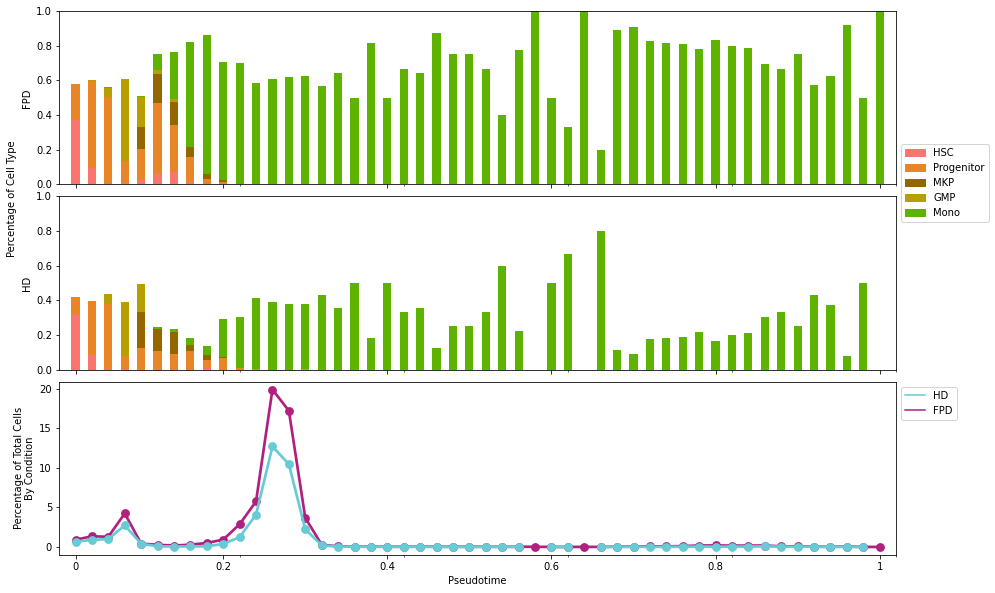

In [30]:
#get path to output directory
path_to_output = os.path.join(os.getcwd(),os.path.dirname(pdf_out))
#change directory to output directory
os.chdir(path_to_output)
#get file name for output file
file_name_out = os.path.basename(pdf_out)
#save plot to output file
plot_pseudotime(adata_ES,df_sets,value_count, save = file_name_out)

In [ ]:
#save data

merged_DF = df_sets['HD'].merge(df_sets['FPD'], on = 'bin', suffixes = ['_HD','_FPD'])
merged_DF = merged_DF[[x for x in list(merged_DF.columns) if x != 'bin'] + ['bin']]
div_size = 0.01
#add a divider
merged_DF.insert(loc=len(clusters_of_interest), column='HD', value=[float(div_size) for _ in range(merged_DF.shape[0])])
merged_DF.insert(loc=len(clusters_of_interest)+1, column='FPD', value=[float(div_size) for _ in range(merged_DF.shape[0])])
merged_DF.to_csv("pseudotime_bar_{}_table.tsv".format(time_call),sep = "\t")

### Make additional plots for other pseudotimes

In [ ]:

time_call = "latent_time"
df_sets,value_count = df_pseudotime(adata_ES, time = time_call, n_bins=50,by_cond = condition, val_counts=val_counts)
#save to output file
file_name_out = "bar_pseudotime_{}_lineplot.pdf".format(time_call)
plot_pseudotime(adata_ES,df_sets,value_count, save = file_name_out)

In [ ]:
#save data

merged_DF = df_sets['HD'].merge(df_sets['FPD'], on = 'bin', suffixes = ['_HD','_FPD'])
merged_DF = merged_DF[[x for x in list(merged_DF.columns) if x != 'bin'] + ['bin']]
div_size = 0.01
#add a divider
merged_DF.insert(loc=len(clusters_of_interest), column='HD', value=[float(div_size) for _ in range(merged_DF.shape[0])])
merged_DF.insert(loc=len(clusters_of_interest)+1, column='FPD', value=[float(div_size) for _ in range(merged_DF.shape[0])])
merged_DF.to_csv("pseudotime_bar_{}_table.tsv".format(time_call),sep = "\t")

In [ ]:
time_call = "velocity_pseudotime"
df_sets,value_count = df_pseudotime(adata_ES, time = time_call, n_bins=50,by_cond = condition, val_counts=val_counts)
#save to output file
file_name_out = "bar_pseudotime_{}_lineplot.pdf".format(time_call)
plot_pseudotime(adata_ES,df_sets,value_count, save = file_name_out)

In [ ]:
#save data

merged_DF = df_sets['HD'].merge(df_sets['FPD'], on = 'bin', suffixes = ['_HD','_FPD'])
merged_DF = merged_DF[[x for x in list(merged_DF.columns) if x != 'bin'] + ['bin']]
div_size = 0.01
#add a divider
merged_DF.insert(loc=len(clusters_of_interest), column='HD', value=[float(div_size) for _ in range(merged_DF.shape[0])])
merged_DF.insert(loc=len(clusters_of_interest)+1, column='FPD', value=[float(div_size) for _ in range(merged_DF.shape[0])])
merged_DF.to_csv("pseudotime_bar_{}_table.tsv".format(time_call),sep = "\t")